# Introductory Fitr Tutorial 

This tutorial will guide you through basic use of the `fitr` package. We will model a simple 2-armed bandit task with subjects whose parameters we will know ahead of time, and subsequently use `fitr` to infer the data-generating model and its most likely parameters.

## Importing

You will need to import the fitr package, and specific modules including `tasks`, which for the present case includes pre-built model of the bandit task with reward probabilities that vary according to a Gaussian random walk over trials. Other models you will need to import include `loglik_functions` (the appropriate loglikelihood functions for model-fitting), and `model_selection`, which we will use last.

In [1]:
import numpy as np
import fitr
from fitr import tasks, model_selection 
from fitr import loglik_functions as ll

% matplotlib inline

## Generate data for the task 

First, we can specify the number of subjects, and initialize an array $\boldsymbol\theta \in \mathbb{R}^{N \times K}$ where $N$ is the number of subjects, and $K$ is the number of parameters in the model. Here, we will set $N$ to 50 subjects, and $K$ will be 2.

In [2]:
nsubjects = 50
params = np.zeros([nsubjects, 2])

Now we must populate the parameter array with values for each parameter (i.e. each column). To do this we can use the pre-built reinforcement learning parameter objects in `fitr`, from which we can sample according to pre-set prior distributions. Here we will sample from a `LearningRate()` object (which has a relatively flat Beta prior), and a `ChoiceRandomness()` object (which is Gamma distributed).

In [3]:
params[:,0] = fitr.LearningRate().dist.rvs(size=nsubjects)
params[:,1] = fitr.ChoiceRandomness().dist.rvs(size=nsubjects)

We can now run these subjects on the task. Note that in the current implementations of the Bandit task, only the two parameter model described here is supported. We are working on soon adding the ability to simulate arbitrary models in these tasks.

In [4]:
task_results = tasks.bandit(narms=2).simulate(ntrials=100, params=params)

Let's check the task results to see that indeed subjects gradually accumulated reward.

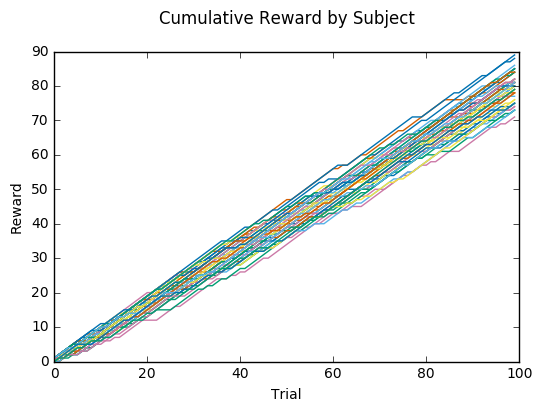

In [5]:
task_results.plot_cumreward()

If one was conducting this experiment on human subjects, he or she would not know the underlying parameters, as we do here. The problem, then becomes finding accurate estimates of the unknown parameters underlying the data generating process in human subjects. Fortunately, `fitr` can manage that using a method developed by Huys et al. (2011). It is that to which we now turn.

## Model-Fitting 

In the present case, we know that the true underlying model is a $\mathcal{Q}$-learning model with two free parameters, $\alpha$ (learning rate), and $\beta$ (choice randomness). Let's construct that model in order to estimate the parameters.

In [6]:
lrcr_model = fitr.fitrmodel(name=r'\lbrace \alpha, \beta \rbrace',
                            loglik_func=ll.bandit_ll(narms=2).lr_cr, 
                            params=[fitr.LearningRate(), fitr.ChoiceRandomness()])

Fitting the model is now reduced to a single command:

In [7]:
lrcr_fit = lrcr_model.fit(data=task_results.data)

ITERATION: 1 | [E-STEP] SUBJECT: 1
ITERATION: 1 | [E-STEP] SUBJECT: 2
ITERATION: 1 | [E-STEP] SUBJECT: 3
ITERATION: 1 | [E-STEP] SUBJECT: 4
ITERATION: 1 | [E-STEP] SUBJECT: 5
ITERATION: 1 | [E-STEP] SUBJECT: 6
ITERATION: 1 | [E-STEP] SUBJECT: 7
ITERATION: 1 | [E-STEP] SUBJECT: 8
ITERATION: 1 | [E-STEP] SUBJECT: 9
ITERATION: 1 | [E-STEP] SUBJECT: 10
ITERATION: 1 | [E-STEP] SUBJECT: 11
ITERATION: 1 | [E-STEP] SUBJECT: 12
ITERATION: 1 | [E-STEP] SUBJECT: 13
ITERATION: 1 | [E-STEP] SUBJECT: 14
ITERATION: 1 | [E-STEP] SUBJECT: 15
ITERATION: 1 | [E-STEP] SUBJECT: 16
ITERATION: 1 | [E-STEP] SUBJECT: 17
ITERATION: 1 | [E-STEP] SUBJECT: 18
ITERATION: 1 | [E-STEP] SUBJECT: 19
ITERATION: 1 | [E-STEP] SUBJECT: 20
ITERATION: 1 | [E-STEP] SUBJECT: 21
ITERATION: 1 | [E-STEP] SUBJECT: 22
ITERATION: 1 | [E-STEP] SUBJECT: 23
ITERATION: 1 | [E-STEP] SUBJECT: 24
ITERATION: 1 | [E-STEP] SUBJECT: 25
ITERATION: 1 | [E-STEP] SUBJECT: 26
ITERATION: 1 | [E-STEP] SUBJECT: 27
ITERATION: 1 | [E-STEP] SUBJECT: 28
I

We can check that the model fit was improved over Expectation-Maximization steps with the following command:

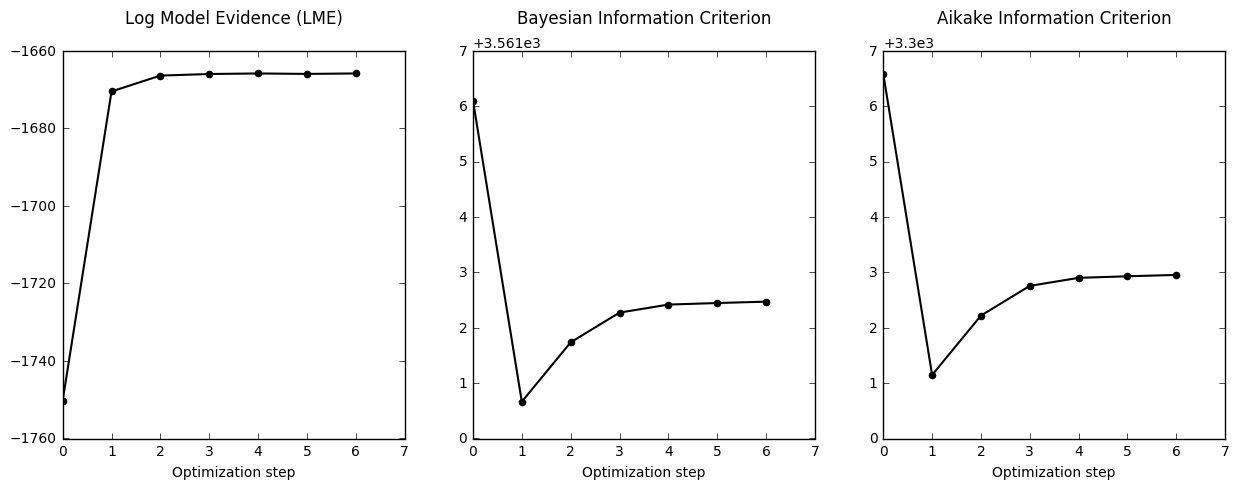

In [8]:
lrcr_fit.plot_fit_ts()

We would be generally happy with this case because LME is persistently increasing and then plateaus.

We can now plot the actual vs. estimated parameters. The closer the dots lie to the diagonal line, the better the fit.

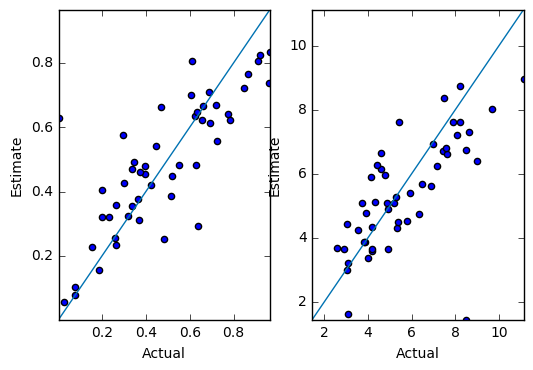

In [9]:
lrcr_fit.plot_ae(actual=task_results.params)

But what about if subjects are using different models? We should be estimating different potential model structures, which we can do by virtue of the `loglik_functions` module containing various log-likeihood functions for the same task, each corresponding to a different set of free-parameters. Here, we will add a model with a 'reward sensitivity' parameter, $\rho$, i.e.  

$$
\mathcal{Q}_t (s_t, a_t) = \mathcal{Q}_{t-1} (s_t, a_t) + \alpha (\rho \cdot r_t + \mathcal{Q}_{t-1} (s_t, a_t)), 
$$

and a model that does not learn, which we will call 'dummy model.' The dummy model will only have an inverse softmax temperature (i.e. 'choice randomness').

In [10]:
# Model with reward sensitivity
lrcrrs_model = fitr.fitrmodel(name=r'\lbrace \alpha, \beta, \rho \rbrace',
                              loglik_func=ll.bandit_ll(narms=2).lr_cr_rs, 
                              params=[fitr.LearningRate(), 
                                      fitr.ChoiceRandomness(), 
                                      fitr.RewardSensitivity()])

# Dummy model 
dummy_model = fitr.fitrmodel(name='Dummy', 
                             loglik_func=ll.bandit_ll(narms=2).dummy, 
                             params=[fitr.ChoiceRandomness()])

#Fit the models 
lrcrrs_fit = lrcrrs_model.fit(data=task_results.data)
dummy_fit = dummy_model.fit(data=task_results.data)

ITERATION: 1 | [E-STEP] SUBJECT: 1
ITERATION: 1 | [E-STEP] SUBJECT: 2
ITERATION: 1 | [E-STEP] SUBJECT: 3
ITERATION: 1 | [E-STEP] SUBJECT: 4
ITERATION: 1 | [E-STEP] SUBJECT: 5
ITERATION: 1 | [E-STEP] SUBJECT: 6
ITERATION: 1 | [E-STEP] SUBJECT: 7
ITERATION: 1 | [E-STEP] SUBJECT: 8
ITERATION: 1 | [E-STEP] SUBJECT: 9
ITERATION: 1 | [E-STEP] SUBJECT: 10
ITERATION: 1 | [E-STEP] SUBJECT: 11
ITERATION: 1 | [E-STEP] SUBJECT: 12
ITERATION: 1 | [E-STEP] SUBJECT: 13
ITERATION: 1 | [E-STEP] SUBJECT: 14
ITERATION: 1 | [E-STEP] SUBJECT: 15
ITERATION: 1 | [E-STEP] SUBJECT: 16
ITERATION: 1 | [E-STEP] SUBJECT: 17
ITERATION: 1 | [E-STEP] SUBJECT: 18
ITERATION: 1 | [E-STEP] SUBJECT: 19
ITERATION: 1 | [E-STEP] SUBJECT: 20
ITERATION: 1 | [E-STEP] SUBJECT: 21
ITERATION: 1 | [E-STEP] SUBJECT: 22
ITERATION: 1 | [E-STEP] SUBJECT: 23
ITERATION: 1 | [E-STEP] SUBJECT: 24
ITERATION: 1 | [E-STEP] SUBJECT: 25
ITERATION: 1 | [E-STEP] SUBJECT: 26
ITERATION: 1 | [E-STEP] SUBJECT: 27
ITERATION: 1 | [E-STEP] SUBJECT: 28
I

## Model Comparison and Selection 

Which of the above models is the one that best fits the data? For this quesiton, we have incorporated Bayesian Model Selection (Rigoux et al., 2014) into `fitr`. This can easily be performed using the following command:

In [11]:
bms_results = model_selection.BMS(model_fits=[lrcr_fit, lrcrrs_fit, dummy_fit], c_limit=1e-100).run()

===== STARTING BAYESIAN MODEL SELECTION =====
Number of models: 3
Subjects: 50
Convergence limit: 1e-100

[BMS] ITERATION: 1
[BMS] ITERATION: 2
[BMS] ITERATION: 3
[BMS] ITERATION: 4
[BMS] ITERATION: 5
[BMS] ITERATION: 6
[BMS] ITERATION: 7
[BMS] ITERATION: 8
[BMS] ITERATION: 9


/home/abraham/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


Now you can plot the protected exceedance probabilities to determine which model is the most probable in this group of subjects:

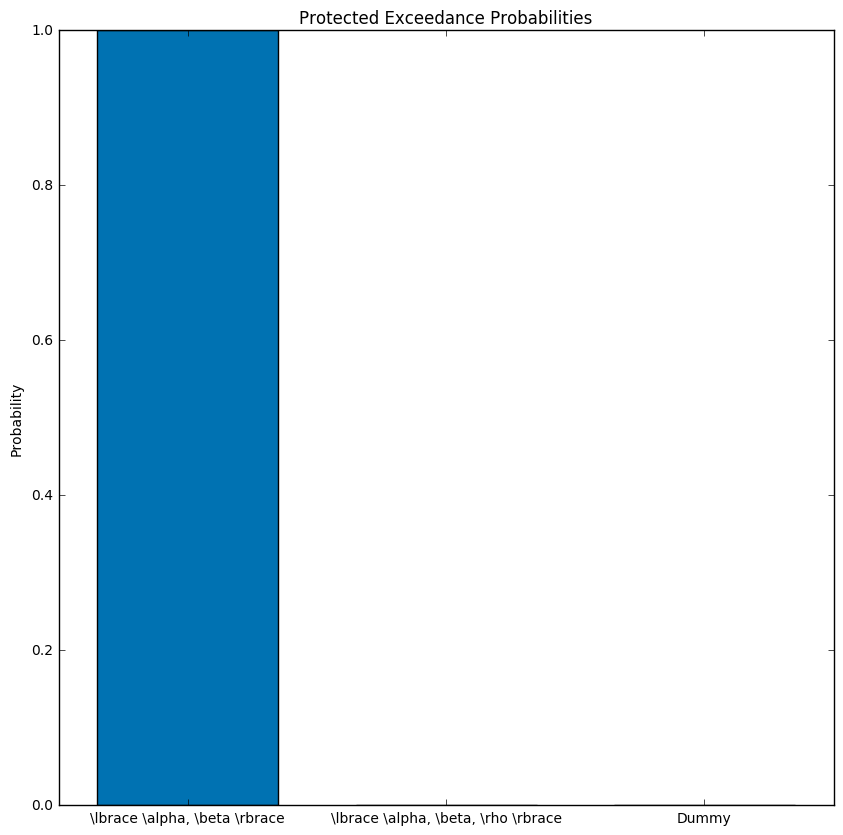

In [12]:
bms_results.plot(statistic='pxp')